# 重新实现之前的线性热模型
应该只需要读取第一次实验的数据，这里主要想规范一下之前的写法

In [1]:
import pandas as pd
import numpy as np
import os
from keys import *
import math

from tqdm import tqdm
from loader import Loader
from thermal_model.data import *
from thermal_model.configs import *
from thermal_model.figure_plotter import *
from utils_thermal_model_raw_process import *
import matplotlib.pyplot as plt
from plotter import Plotter
import seaborn as sns
from sklearn.linear_model import LinearRegression,Lars
from sklearn.ensemble import RandomForestRegressor
from thermal_model.thermal_model import fit_random_forest, model_estimator,fit_LARS
import pickle
import math

# 读取数据并且缓存成单独pickle

In [ ]:
df_thermal_model_data_raw = ThermalModelData().load()

# 生成线性模型的输入项

In [ ]:
df_thermal_model_data_input = generate_model_input(df_thermal_model_data_raw)

In [ ]:
df_thermal_model_data_input.columns

# 生成模型（应该使用线性模型）

In [ ]:
model_random_forest,model_input,model_target = fit_random_forest(df_thermal_model_data_input,6)

In [ ]:
( model_predict, error) = model_estimator(
    model_random_forest,model_input,model_target
)

In [ ]:
Thermal_model_regression_scatter(
    model_target = model_target,
    model_predict = model_predict,
    title_model="随机森林",
).save()

In [ ]:
Thermal_model_regression_error_histplot(
    model_target=model_target,
    error=error,
    title_model="随机森林"
).save()

In [ ]:
Thermal_model_regression_cumulative_error_plot(
    model_target=model_target,
    model_predict=model_predict
).save()

In [ ]:
model_lars,model_input,model_target = fit_LARS(df_thermal_model_data_input)

In [ ]:
( model_predict, error) = model_estimator(
    model_lars,model_input,model_target
)

In [ ]:
Thermal_model_regression_scatter(
    model_target = model_target,
    model_predict = model_predict,
    title_model="LARS",
).save()

In [ ]:
Thermal_model_regression_error_histplot(
    model_target=model_target,
    error=error,
    title_model="LARS"
).save()

In [ ]:
Thermal_model_regression_cumulative_error_plot(
    model_target=model_target,
    model_predict=model_predict,
    title_model='LARS'
).save()

# 测试模型功能

In [2]:
from thermal_model.original_thermal_model_and_plotter_0117 import Electrolyzer as ele_ori
from thermal_model.original_thermal_model_and_plotter_0117 import *

In [3]:
ele_ori_model = ele_ori()
ele_ori_model.merge_coef()

In [4]:
from thermal_model.electrolyzer import Electrolyzer
electrolyzer = Electrolyzer()

In [5]:
class Model_output_temperature_different_lye_temperature(Plotter):
    def __init__(
        self, 
        label="Thermal model", 
        title="不同碱液入口温度下电解槽出口温度", 
        num_subplot=4, 
        title_plot=True
    ) -> None:
        from thermal_model.electrolyzer import Electrolyzer
        super().__init__(label, title, num_subplot, title_plot)
        self.electrolyzer = Electrolyzer()
    
    def plot_1(self):
        #不同碱液入口温度下电解槽出口温度
        plt.subplot(2,2,1)
        lye_temperature_range = range(35,95,1)
        current_range = range(50,2050,25)
        ambient_temperature = OperatingCondition.Default.ambient_temperature
        lye_flow = OperatingCondition.Default.lye_flow
        temperature_matrix = np.ones(
            (
                len(lye_temperature_range),
                len(current_range)
            )
        ) # 出口温度
        for i in range(len(current_range)):
            for j in range(len(lye_temperature_range)):
                1
                temperature_matrix[j,i] = (
                    self.electrolyzer.temperature_thermal_balance_current(
                        ambient_temperature=ambient_temperature,
                        lye_flow=lye_flow,
                        lye_temperature=lye_temperature_range[j],
                        current = current_range[i]
                    )
                )
                if (
                    lye_temperature_range[j] == OperatingCondition.Rated.lye_temperature
                ) and (
                    current_range[i]==OperatingCondition.Rated.current
                ):
                    temperature_default = temperature_matrix[j,i]
                if (
                    lye_temperature_range[j] == OperatingCondition.Optimal.lye_temperature
                ) and (
                    current_range[i]==OperatingCondition.Optimal.current
                ):
                    temperature_optimal = temperature_matrix[j,i]
                    
        temperature_maximum = max(temperature_matrix.flatten())
        temperature_minimum = min(temperature_matrix.flatten())
        contour_levels = np.arange(
            temperature_minimum,
            temperature_maximum,
            (temperature_maximum - temperature_minimum)/10
        )
        contour_figure = plt.contourf(
            np.array(current_range) / self.electrolyzer.active_surface_area,
            lye_temperature_range,
            temperature_matrix,
            contour_levels,
            origin = 'upper'
        )
        plt.clabel(contour_figure, colors="w", fmt="%2.0f", fontsize=12)
        plt.xlabel(r'$Current\ density (A/m^2)$')
        plt.ylabel(r'$Lye inlet temperature (^\circ C)$')
        plt.colorbar(
            contour_figure
        )
        # 画出额定功率点
        plt.text(
            OperatingCondition.Rated.current_density+PlotterOffset.Marker.Cross.Subplot4.current_density,
            OperatingCondition.Rated.lye_temperature+PlotterOffset.Marker.Cross.Subplot4.lye_temperature,
            '+',
            color=OperatingCondition.Rated.color,
            fontdict={
                'size':PlotterOffset.Marker.Cross.Subplot4.font_size
            }
        )    
        plt.text(
            OperatingCondition.Rated.current_density-PlotterOffset.Marker.Cross.Subplot4.current_density,
            OperatingCondition.Rated.lye_temperature-PlotterOffset.Marker.Cross.Subplot4.lye_temperature,
            str(np.round(temperature_default,1) )+ r'$^\circ C$',
            color=OperatingCondition.Rated.color,
            fontdict={
                'size':PlotterOffset.Marker.Cross.Subplot4.font_size
            }
        )    
        # 画出最优工况点
        plt.text(
            OperatingCondition.Optimal.current_density+PlotterOffset.Marker.Cross.Subplot4.current_density,
            OperatingCondition.Optimal.lye_temperature+PlotterOffset.Marker.Cross.Subplot4.lye_temperature,
            '+',
            color=OperatingCondition.Rated.color,
            fontdict={
                'size':PlotterOffset.Marker.Cross.Subplot4.font_size
            }
        )    
        plt.text(
            OperatingCondition.Optimal.current_density-PlotterOffset.Marker.Cross.Subplot4.current_density,
            OperatingCondition.Optimal.lye_temperature-PlotterOffset.Marker.Cross.Subplot4.lye_temperature,
            str(np.round(temperature_optimal,1) )+ r'$^\circ C$',
            color=OperatingCondition.Rated.color,
            fontdict={
                'size':PlotterOffset.Marker.Cross.Subplot4.font_size
            }
        ) 
        
    
    def plot_2(self):
        # 额定点工况温度随碱液流量的变化
        plt.subplot(2,2,2)
        lye_flow_range = np.arange(0.6,2.1,0.1)
        current = OperatingCondition.Rated.current
        lye_temperature = OperatingCondition.Rated.lye_temperature
        temperature_list = []
        voltage_list = []
        for lye_flow in lye_flow_range:
            temperature_cur = self.electrolyzer.temperature_thermal_balance_current(
                ambient_temperature= self.electrolyzer.default_ambient_temperature,
                lye_flow= lye_flow,
                lye_temperature = lye_temperature,
                current=current
            )
            voltage_cur = self.electrolyzer.polar_current_lh(
                current = current,
                temperature=temperature_cur
            )
            temperature_list.append(temperature_cur)
            voltage_list.append(voltage_cur)
        
        ax1,ax2 = self.plot_double_y_axis(
            x = lye_flow_range,
            y1 = temperature_list,
            y2 = voltage_list,
            x_title = r'$Lye\ flow (m^3/h)$',
            y1_title= r'$Outlet temperature (^\circ C)$',
            y2_title='Stack voltage (V)',
        )
        ax2.set_ylim([65,70])


    def plot_3(self):
        # 额定点工况温度随的变化
        plt.subplot(2,2,3)
        lye_flow = OperatingCondition.Default.lye_flow
        ambient_temperature_range = range(-15,41,1)
        current = OperatingCondition.Rated.current
        lye_temperature = OperatingCondition.Rated.lye_temperature
        temperature_list = []

        for ambient_temperature in ambient_temperature_range:
            temperature_cur = self.electrolyzer.temperature_thermal_balance_current(
                ambient_temperature=ambient_temperature,
                lye_flow= lye_flow,
                lye_temperature = lye_temperature,
                current=current
            )
            temperature_list.append(temperature_cur)
        plt.plot(
            ambient_temperature_range,
            temperature_list,
            label = 'Outlet temperature'
        )
        plt.xlabel(r'$Ambient\ temperature (^\circ C)$')
        plt.ylabel(r'$Outlet temperature (^\circ C)$')

    def plot_4(self):
        plt.subplot(2,2,4)
    def plot(self):
        self.plot_1()
        self.plot_2()
        self.plot_3()
        self.plot_4()

figure saved at Thermal model 不同碱液入口温度下电解槽出口温度


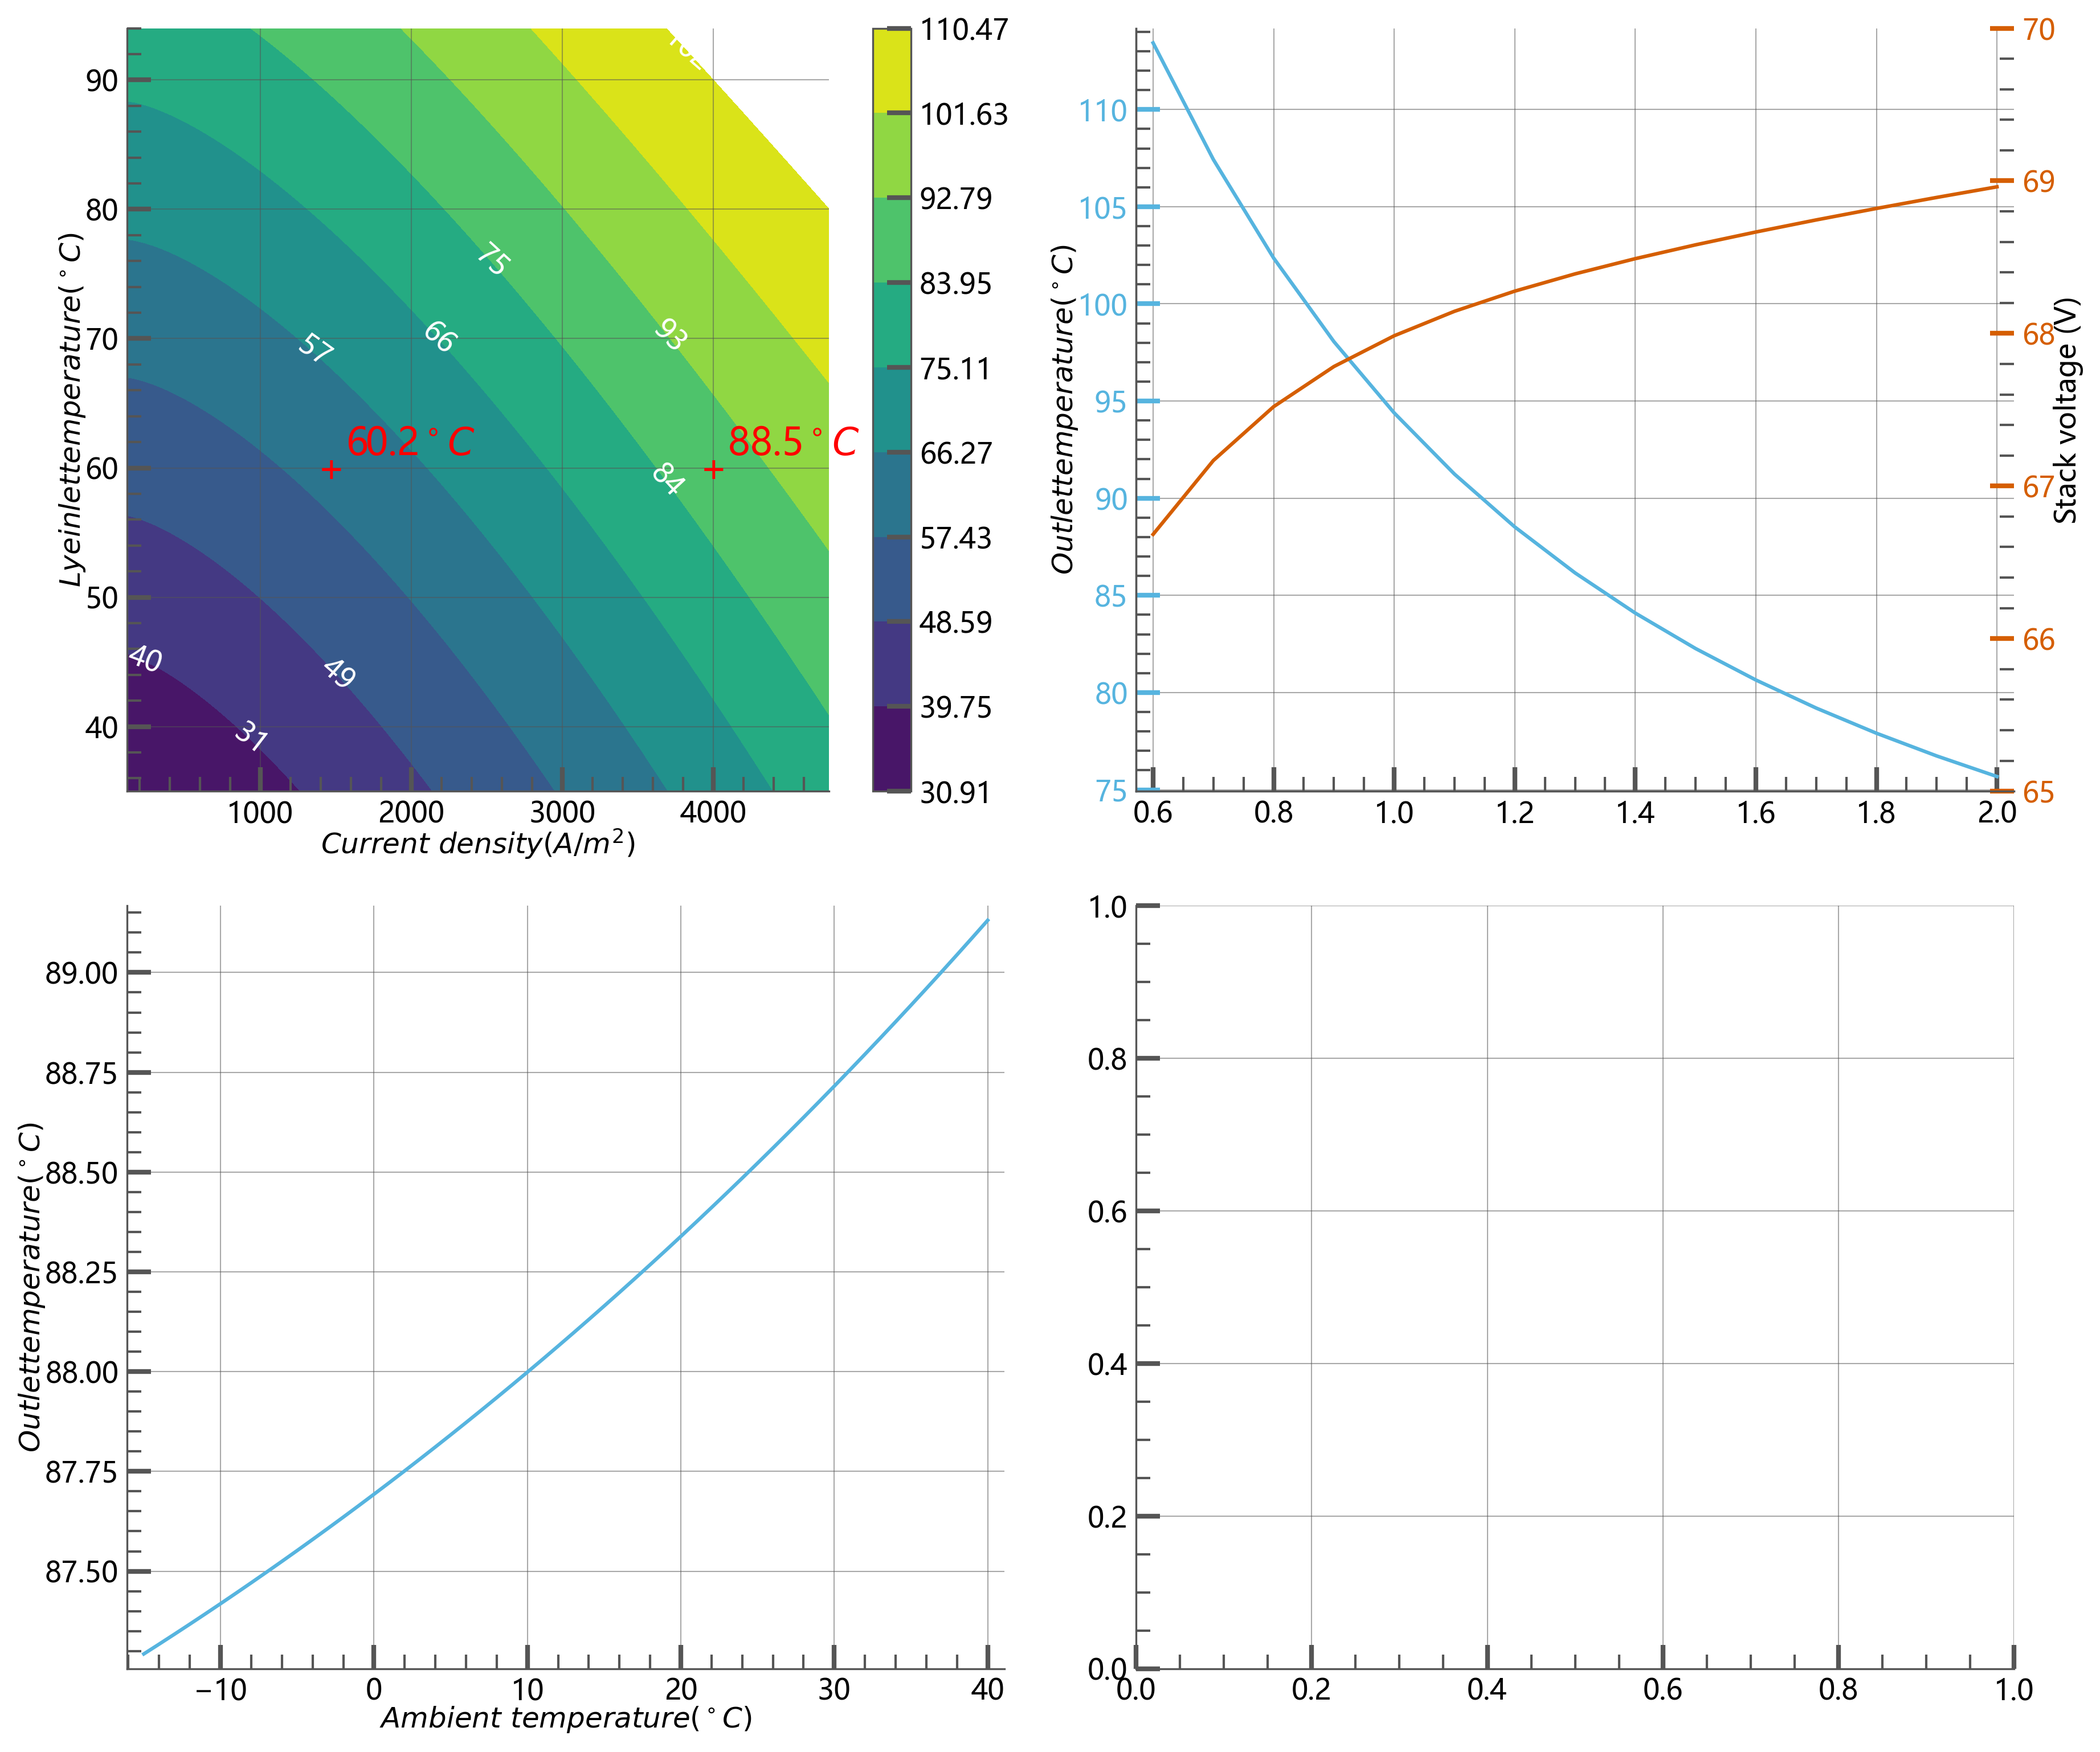

In [6]:
Model_output_temperature_different_lye_temperature().save()

In [ ]:
lye_flow_range = np.arange(0.6,2.1,0.1)
current = OperatingCondition.Optimal.current
lye_temperature = OperatingCondition.Optimal.lye_temperature
temperature_list = []

for lye_flow in lye_flow_range:
    temperature_cur = electrolyzer.temperature_thermal_balance_current(
        ambient_temperature= electrolyzer.default_ambient_temperature,
        lye_flow= lye_flow,
        lye_temperature = lye_temperature,
        current=current
    )
    temperature_list.append(temperature_cur)
plt.plot(
    lye_flow_range,
    temperature_list
)
plt.xlabel(r'$Lye\ flow (m^3/h)$')
plt.ylabel(r'$Outlet temperature (^\circ C)$')

In [ ]:
plt.show()

In [ ]:
(
    current_list,
    voltage_list,
    power_list,
    temperature_list
) = electrolyzer.get_default_polarization()

In [ ]:
electrolyzer.temperature_thermal_balance_current(
    ambient_temperature=15,
    lye_flow=1.5,
    lye_temperature=10,
    current=0
)